In [1]:
!pip install matplotlib
#mc cp s3/tordjx ummt --recursive
# watch -n 0.5 nvidia-smi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 50.1 MB/s eta 0:00:00


In [2]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size)
#Data non batchés
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head =4 
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 1024
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 512

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"]).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"]).to(device)

#IF WE WANT TO LOAD PREVIOUSLY TRAINED MODEL
model_en.load_state_dict(torch.load("tordjx/model_en"))
model_fr.load_state_dict(torch.load("tordjx/model_fr"))

<All keys matched successfully>

In [3]:
# val_features  = np.load(fs.open('tordjx/val-resnet50-res4frelu.npy'))
# train_features  = np.load(fs.open('tordjx/train-resnet50-res4frelu.npy'))
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
# val_features = np.load("C:/Users/lucas/Desktop/val-resnet50-res4frelu.npy")
train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
val_features = np.load("tordjx/val-resnet50-res4frelu.npy")
train_features = torch.from_numpy(train_features)
val_features = torch.from_numpy(val_features)

In [ ]:
train_data_fr = [tokenized_fr, train_features]
train_data_en = [tokenized_en, train_features]
mixed_train(model_fr,model_en,train_data_fr,train_data_en,500,batch_size, True,[1/2,1])


11.578482758620689


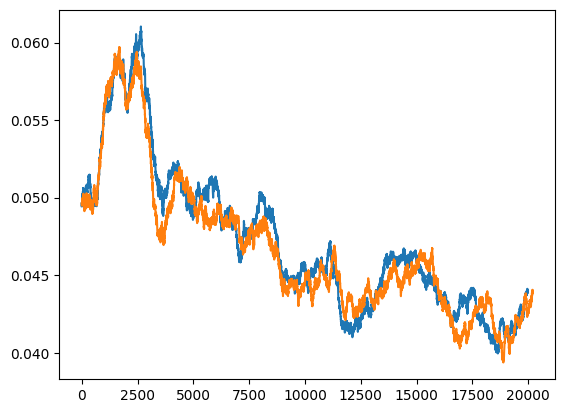

In [7]:
def moving_average(a, n=1000,tail = 0) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return (ret[n - 1:] / n)[tail:]

plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
# plt.plot(model_en.loss_list)
print(len(model_fr.loss_list)/(29000/batch_size))


In [10]:
torch.save(model_fr.state_dict(), "tordjx/model_fr")
torch.save(model_en.state_dict(), "tordjx/model_en")
import os
import s3fs
!pip install pandas
import pandas
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
fs.upload("tordjx/model_fr","tordjx/model_fr")
fs.upload("tordjx/model_en","tordjx/model_en")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 25.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 19.8 MB/s eta 0:00:00


In [11]:
def greedy_decode(model_A,model_B, src, max_len=97):
    start_symbol = model_B.begin_id
    
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys
tokenized_fr.shape


def cycle_consistent_forward(model_A,model_B,text_input, image_input = None, image_bool = False) : 
    EOS_IDX= model_B.end_id
    start_symbol= model_B.begin_id
    max_len = 97
    src_mask = model_A.generate_square_subsequent_mask(model_A.n_head*text_input.shape[0],text_input.shape[1]) # square mask 
    tgt_mask = model_A.generate_square_subsequent_mask(model_A.n_head*text_input.shape[0],text_input.shape[1])
    src_padding_mask  = (text_input== model_A.padding_id).to(device=device)
    tgt_padding_mask = (text_input==  model_A.padding_id).to(device=device)
    memory_mask = model_A.generate_square_subsequent_mask(text_input.shape[0],text_input.shape[1])
    memory_key_padding_mask = (text_input ==  model_A.padding_id).to(device=device)
    if image_bool:
        mem_ei_mask = torch.zeros([text_input.shape[0], text_input.shape[1], text_input.shape[1] + image_input.shape[1]]).to(device=device,dtype = bool)
        mem_ei_mask[:,0:text_input.shape[1], 0:text_input.shape[1]] = model_A.generate_square_subsequent_mask(text_input.shape[0],text_input.shape[1]).to(device=device)
        mem_ei_key_padding_mask = (text_input ==  model_A.padding_id).to(device=device)
        mem_ei_key_padding_mask = torch.cat((mem_ei_key_padding_mask, torch.full([text_input.shape[0], image_input.shape[1]], False).to(device=device)), dim=1)
    memory = model_A.encoder(model_A.positional_encoder(model_A.embedding(text_input)),src_mask,src_padding_mask)
    
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    
    if image_bool:
        mem_masks = [memory_mask, mem_ei_mask]
        mem_padding_masks = [memory_key_padding_mask, mem_ei_key_padding_mask]
        image_encoded = model_A.feedforward(image_input)
        x = [text_encoded, image_encoded]
        output = model_B.decoder(x,model_A.positional_encoder(model_A.embedding(text_input)), tgt_mask , mem_masks , tgt_padding_mask, mem_padding_masks)

    else:
        x = text_encoded
        output = model_B.decoder(x,model_A.positional_encoder(model_A.embedding(text_input)), tgt_mask , [memory_mask] , tgt_padding_mask, [memory_key_padding_mask])
    for i in range(max_len-1):
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys
    
    
    return model_B.output_layer(output)


torch.Size([29000, 97])

In [8]:
#%%
train_data_fr = [tokenized_fr, train_features]
train_data_en = [tokenized_en, train_features]
def tensor_to_sentence(output,inv_dic):
    result = [inv_dic[int(x)] for x in output]
    sentence = ""
    for word in result : 
        if word == "DEBUT_DE_PHRASE" or word == "TOKEN_VIDE" :
            pass
        elif '@@' in word: 
            sentence+=word[:-2]
        elif word == "FIN_DE_PHRASE" :
            break 
        
        else :
            sentence+=word +" "
    return sentence

def traduit(model_A,model_B,data, inv_map,image_bool):
    model_en.eval()
    model_fr.eval()
    if image_bool : 
        data,features= data
    output = torch.argmax(cycle_consistent_forward(model_A,model_B,data,features, True),dim = 2)[j]
    return tensor_to_sentence(output.view(-1),inv_map)



def donne_random():
    i = np.random.randint(len(tokenized_en)//batch_size)
    j = np.random.randint(batch_size)
    batched_data=batchify(train_data_en,batch_size,True)
    data,features = batched_data
    return data[i],features[i]

text,features = donne_random()
features = features.to(device,dtype=torch.float32)
data = [text,features]
for i in range(10):
    j = np.random.randint(batch_size)
    print("Phrase à traduire : \n" + tensor_to_sentence(text[j],inv_map_en)+ "\n Phrase traduite : \n "+ traduit(model_en,model_fr,data, inv_map_fr,True))


#%%

Phrase à traduire : 
a woman jumping in a desert like area . 
 Phrase traduite : 
 un homme s&apos; une un devant ianer c verte ch
Phrase à traduire : 
person observing a river with a bridge going over it . 
 Phrase traduite : 
 cinq une sur ian, dun vêtus se un tas équipe poson co
Phrase à traduire : 
a woman with a nike hat hard at work . 
 Phrase traduite : 
 un homme se un e. l
Phrase à traduire : 
person observing a river with a bridge going over it . 
 Phrase traduite : 
 cinq une sur ian, dun vêtus se un tas équipe poson co
Phrase à traduire : 
people shop for goods at a fruit stand . 
 Phrase traduite : 
 pc se vune une noirs est un masque chaise ch
Phrase à traduire : 
a playful dog is jumping on the sand . 
 Phrase traduite : 
 un oy jad&apos; caenfants en s&apos; sébuvant rh
Phrase à traduire : 
a newlywed couple stands in front of a large crowd . 
 Phrase traduite : 
 un ede edes jekmtenue une porte dans un bleu veste co
Phrase à traduire : 
a woman with a nike hat hard at 